In [4]:
!pip install -U transformers --quiet

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import nltk

In [68]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [9]:
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [12]:
df.shape,df.columns

((568454, 10),
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
        'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
       dtype='object'))

In [27]:
df['HelpfulnessDenominator'].value_counts()

HelpfulnessDenominator
0      270052
1      112753
2       61482
3       34394
4       22306
        ...  
197         1
488         1
383         1
219         1
815         1
Name: count, Length: 234, dtype: int64

In [28]:
df.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [34]:
df_numeric = df[[col for col in ['HelpfulnessNumerator','HelpfulnessDenominator','Score','Time']]]
df_numeric.columns

Index(['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time'], dtype='object')

<Axes: >

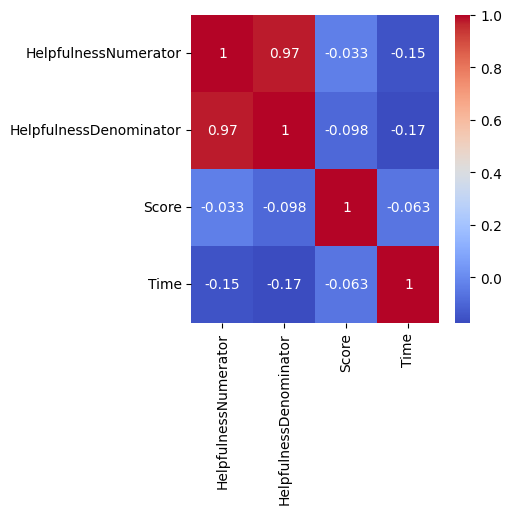

In [30]:
plt.figure(figsize=(4,4))
sns.heatmap(df_numeric.corr(),annot=True,cmap='coolwarm')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='HelpfulnessNumerator', ylabel='Density'>

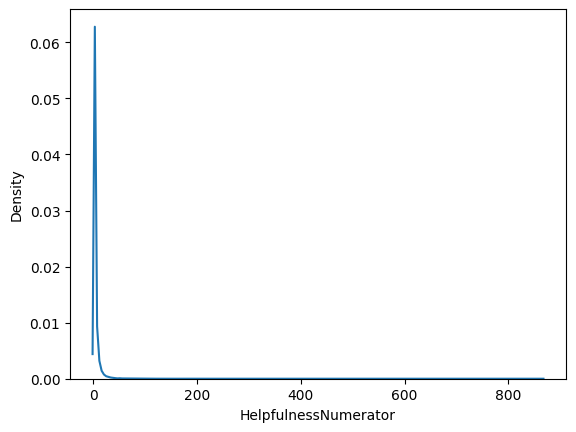

In [35]:
sns.kdeplot(data=df_numeric, x="HelpfulnessNumerator")

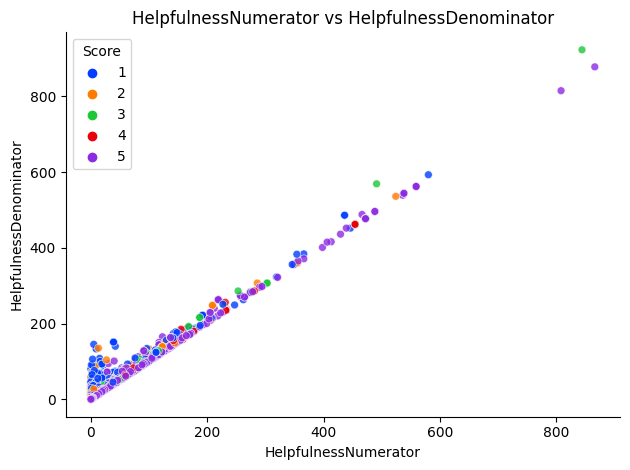

In [32]:
sns.scatterplot(data=df,x='HelpfulnessNumerator',y='HelpfulnessDenominator',hue='Score',
              palette='bright',s=32,alpha=0.8)

plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('HelpfulnessNumerator')
plt.ylabel('HelpfulnessDenominator')
plt.title('HelpfulnessNumerator vs HelpfulnessDenominator')
plt.tight_layout()
plt.show()

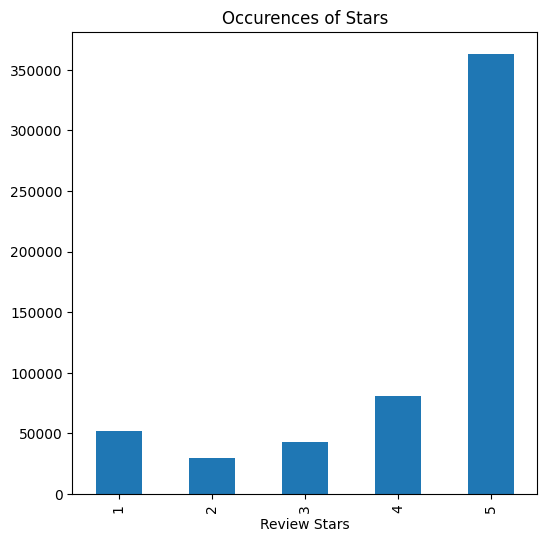

In [43]:
ax = df['Score'].value_counts().sort_index().plot(
    kind = 'bar' , title = 'Occurences of Stars',
    figsize = (6,6)
)
ax.set_xlabel('Review Stars')
plt.show()

In [44]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [66]:
sample = df['Text'][50]
tokens = nltk.word_tokenize(sample)
print(tokens)

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft', ',', 'I', 'do', "n't", 'like', 'it', '.', 'Quaker', 'Oats', 'is', 'the', 'way', 'to', 'go', '.']


In [69]:
tagged = nltk.pos_tag(tokens)
tagged

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ'),
 (',', ','),
 ('I', 'PRP'),
 ('do', 'VBP'),
 ("n't", 'RB'),
 ('like', 'VB'),
 ('it', 'PRP'),
 ('.', '.'),
 ('Quaker', 'NNP'),
 ('Oats', 'NNPS'),
 ('is', 'VBZ'),
 ('the', 'DT'),
 ('way', 'NN'),
 ('to', 'TO'),
 ('go', 'VB'),
 ('.', '.')]

In [71]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia = SentimentIntensityAnalyzer()

In [73]:
sample

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [72]:
sia.polarity_scores(sample)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [75]:
scores ={}
for i, row in tqdm(df.iterrows() , total = len(df)):
    text = row['Text']
    ID = row['Id']
    scores[ID] = sia.polarity_scores(text)


  0%|          | 0/568454 [00:00<?, ?it/s]